In [227]:
!pip install pandas numpy scikit-learn torch

In [228]:
# check torch gpu
import torch

device = None

print("<!> Selecting GPU as main device <!>")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
    print("<!> Using: " + torch.cuda.get_device_name(0) + "<!>")
else:
    print("<!> No GPU available <!>")
    exit(0)

<!> Selecting GPU as main device <!>
<!> Using: NVIDIA GeForce GTX 1050<!>


In [229]:
import pandas as pd

print("<!> Loading test dataframe <!>")
test_df = pd.read_csv('/root/test/test_transactions.csv')

<!> Loading test dataframe <!>


In [230]:
import numpy as np

def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

In [231]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

class BiLSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(BiLSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.fc1 = nn.Linear(hidden_size * 2, 64)  # Bidirectional => hidden_size * 2
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  
        last_step_output = lstm_out[:, -1, :]  # Take last time step
        x = self.fc1(last_step_output)
        x = self.relu(x)
        return self.fc2(x)  # Final output layer

# Model setup
INPUT_SIZE = 1
HIDDEN_SIZE = 128
NUM_LAYERS = 3
OUTPUT_SIZE = 1
DROPOUT_RATE = 0.2

model = BiLSTMPredictor(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_RATE).to(device)

<!> Predicting demand for item id 2 <!>
listing states
odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l0_reverse', 'lstm.weight_hh_l0_reverse', 'lstm.bias_ih_l0_reverse', 'lstm.bias_hh_l0_reverse', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'lstm.weight_ih_l1_reverse', 'lstm.weight_hh_l1_reverse', 'lstm.bias_ih_l1_reverse', 'lstm.bias_hh_l1_reverse', 'lstm.weight_ih_l2', 'lstm.weight_hh_l2', 'lstm.bias_ih_l2', 'lstm.bias_hh_l2', 'lstm.weight_ih_l2_reverse', 'lstm.weight_hh_l2_reverse', 'lstm.bias_ih_l2_reverse', 'lstm.bias_hh_l2_reverse', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


/tmp/ipykernel_1151437/1295333312.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/root/test/lstm_trained_data.pth")


Sum of the predicted values for the first month: 9533.3798828125


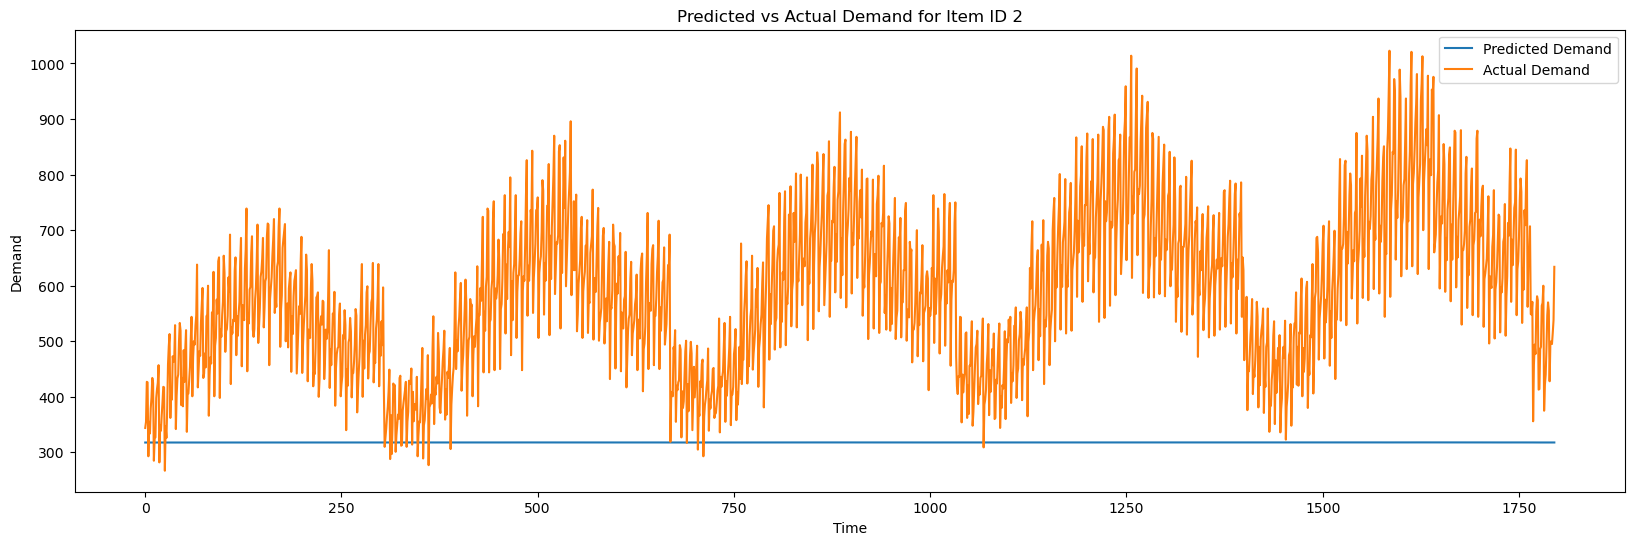

In [232]:
import matplotlib.pyplot as plt

print("<!> Predicting demand for item id 2 <!>")

# Load the model

checkpoint = torch.load("/root/test/lstm_trained_data.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

scaler = MinMaxScaler()
# Prepare the test data
test_series = test_df[str(2)].values.reshape(-1, 1)
train_series = scaler.fit_transform(test_series)
test_series = scaler.transform(test_series)
SEQ_LENGTH = 30 
X_test, y_test = create_sequences(test_series, SEQ_LENGTH)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device)

# Make predictions
with torch.no_grad():
    predictions = model(X_test).cpu().numpy()

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)
first_month_sum = predictions[:30].sum()
print(f"Sum of the predicted values for the first month: {first_month_sum}")

# Plot the predictions
plt.figure(figsize=(20, 6))
plt.plot(predictions, label='Predicted Demand')
plt.plot(scaler.inverse_transform(test_series[SEQ_LENGTH:]), label='Actual Demand')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Predicted vs Actual Demand for Item ID 2')
plt.legend()
plt.show()

In [ ]:
# rmse
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.cpu().numpy()), predictions))
print(f"RMSE: {rmse}")
# print the mean demand vou the first month of the product 2, test data
print(f"Mean demand for the first month of product 2: {scaler.inverse_transform(test_series)[:30].sum()}")

# NRMSE
nrmse = rmse / scaler.inverse_transform(y_test.cpu().numpy()).mean()
print(f"NRMSE: {nrmse}")

RMSE: 306.85539652253146
Mean demand for the first month of product 2: 10035.0
NRMSE: 0.5201484009777362


: 